# Реализация алгоритма CBOW

## Импорты

In [104]:
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from nltk.util import ngrams
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


## Сборка датасета

### Загрузка корпуса

In [105]:
corpus = pd.read_csv("/content/drive/MyDrive/Университет/NLP/corpus.csv")
corpus = corpus["corpus"].apply(lambda text: text.split())
corpus = corpus[np.random.randint(0, len(corpus), 10_000)]
display(corpus[:10], corpus.shape)

,corpus
3238,"[добрый, день, нужно, очистить, сооружение, на..."
14780,"[починить, пожалуйста, лежачий, полицейский, д..."
24666,"[отслоение, штукатурка, стена, потолок, вход, ..."
5085,"[арка, направо, установка, батарея, использова..."
5186,"[месяц, домофон, висеть, украшение, хотя, плат..."
13438,"[незаконный, хранение, коляска, вторм, этаж, п..."
12727,"[вход, лестница, семь, стена, находиться, огол..."
582,"[второй, парадный, металлический, дверь, закры..."
3743,"[холл, третий, этаж, третий, парадный, дверь, ..."
10790,"[отсутствовать, асфальтовый, покрытие, двор, д..."


(10000,)

### Создание пентаграммов

In [106]:
data = []
for doc in corpus:
    data.extend(list(ngrams(doc, n=5)))
df = np.array(data)
display(df[:10], df.shape)

array([['добрый', 'день', 'нужно', 'очистить', 'сооружение'],
       ['день', 'нужно', 'очистить', 'сооружение', 'надпись'],
       ['починить', 'пожалуйста', 'лежачий', 'полицейский', 'двор'],
       ['пожалуйста', 'лежачий', 'полицейский', 'двор', 'хватать'],
       ['отслоение', 'штукатурка', 'стена', 'потолок', 'вход'],
       ['штукатурка', 'стена', 'потолок', 'вход', 'балкон'],
       ['стена', 'потолок', 'вход', 'балкон', 'лестница'],
       ['потолок', 'вход', 'балкон', 'лестница', 'четыре'],
       ['вход', 'балкон', 'лестница', 'четыре', 'этаж'],
       ['балкон', 'лестница', 'четыре', 'этаж', 'семнадцать']],
      dtype='<U21')

(120360, 5)

### Векторизация датасета

In [107]:
vocabulary = sorted(set([word for doc in corpus for word in doc]))
vocabulary = pd.Series(data=range(len(vocabulary)), index=vocabulary, dtype=np.int16)
vocabulary

,0
абразив,0
абрамов,1
абсолютно,2
авангард,3
авангардный,4
...,...
ящик,8248
ёлка,8249
ёлочка,8250
ёмкость,8251


In [108]:
def vectorize(word: str) -> int:
    return vocabulary.loc[word]

vectorized = np.vectorize(vectorize)

In [109]:
df = vectorized(df)
df[:7]

array([[1429, 1342, 3762, 4404, 6834],
       [1342, 3762, 4404, 6834, 3262],
       [5293, 4981, 2784, 5052, 1289],
       [4981, 2784, 5052, 1289, 7841],
       [4350, 8090, 7024, 5267,  828],
       [8090, 7024, 5267,  828,  177],
       [7024, 5267,  828,  177, 2806]], dtype=int16)

In [110]:
x, y = np.delete(df, 2, axis=1), df[:, 2].reshape(-1, 1)
x.shape, y.shape

((120360, 4), (120360, 1))

In [111]:
# pd.DataFrame(df).to_csv("/content/drive/MyDrive/Университет/NLP/vectorized_df.csv", index=False)

### Разделение на тренировочную и тестовую выборку

In [170]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=10, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((120350, 4), (10, 4), (120350, 1), (10, 1))

### Создание DataLoader

In [113]:
train_ds = TensorDataset(
    torch.from_numpy(xtrain).type(torch.int),
    torch.from_numpy(ytrain).type(torch.float)
)
train_dl = DataLoader(train_ds, batch_size=len(xtrain) // 300, shuffle=True)

## Нейронная сеть CBOW

In [114]:
def one_hot(indx):
    vector = np.zeros(len(vocabulary), dtype=np.int8)
    vector[int(indx)] = 1
    return vector

In [115]:
class CBOW(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int,
            linear1_in_features: int, linear1_out_features: int
        ) -> None:
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(linear1_in_features * embedding_dim, linear1_out_features)
        self.linear2 = nn.Linear(linear1_out_features, vocab_size)
        self.loss_values = []

    def forward(self, X: torch.Tensor):
        y = self.embedding(X).view(X.shape[0], -1)
        y = self.linear1(y)
        y = nn.ReLU()(y)
        y = self.linear2(y)
        y = nn.Softmax(dim=1)(y)
        return y

    def fit(self, dataloader, loss, optimizer, n_epohs: int = 30) -> None:
        self.loss_values.clear()
        for _ in tqdm(range(n_epohs), desc="Epoh"):
            for xbatch, ybatch in tqdm(dataloader, desc="Batch", leave=False):
                optimizer.zero_grad()
                outputs = self(xbatch)
                answer = torch.from_numpy(np.apply_along_axis(one_hot, 1, ybatch)).type(torch.float16)
                loss_value = loss(outputs, answer)
                loss_value.backward()
                optimizer.step()
            self.loss_values.append(loss_value.item())


## Обучение модели

In [116]:
model = CBOW(
    vocab_size=len(vocabulary),
    embedding_dim=30,
    linear1_in_features=xtrain.shape[1],
    linear1_out_features=100
)
print(model)

CBOW(
  (embedding): Embedding(8253, 30)
  (linear1): Linear(in_features=120, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=8253, bias=True)
)


In [ ]:
model.fit(
    dataloader=train_dl,
    loss=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=25*1e-4)
)

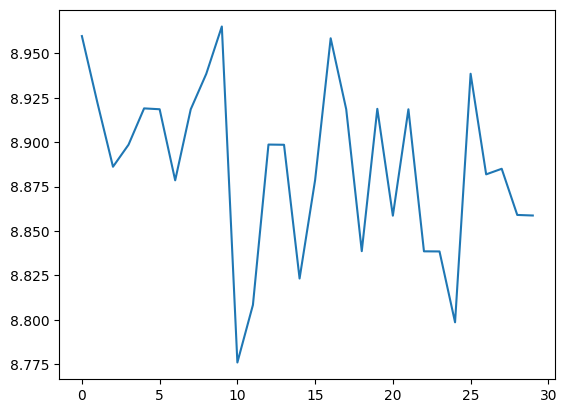

In [119]:
plt.plot(model.loss_values)

In [149]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/Университет/NLP/model.pth")

## Результаты

In [171]:
xtest = torch.from_numpy(xtest).type(torch.int)
ytest = torch.from_numpy(ytest).type(torch.float)
xtest.shape, ytest.shape

(torch.Size([10, 4]), torch.Size([10, 1]))

In [172]:
predict = model.forward(xtest)
predict.shape

torch.Size([10, 8253])

In [163]:
vocab = pd.Series(data=vocabulary.index, index=vocabulary.values)
vocab.head()

,0
0,абразив
1,абрамов
2,абсолютно
3,авангард
4,авангардный


In [152]:
def to_text(number: int):
    return vocab.loc[number]

to_text_func = np.vectorize(to_text)

In [174]:
context = to_text_func(xtest.numpy())
answer = to_text_func(ytest.numpy())
predict = to_text_func(predict.max(axis=1).indices.view(-1, 1).numpy())

pd.DataFrame(np.hstack((context, answer, predict)), columns=list(range(4)) + ["answer", "predict"])

,0,1,2,3,answer,predict
0,наш,санкт,пользователь,портал,петербург,петербург
1,трясти,момент,мотор,время,запуск,двадцать
2,необходимо,стереть,общественный,транспорт,остановка,мусор
3,улица,вавилов,семь,корп,дом,дом
4,улица,сытнинский,косметический,ремонт,провести,этаж
5,который,падать,мочь,продолжаться,убирать,который
6,просить,выдолбить,конец,качественно,работа,установить
7,дворник,развозить,контейнер,специально,мусорный,который
8,график,уборка,общий,пользование,место,место
9,лепиться,песок,очень,сильно,камень,дверь
